In [1]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
import random
import argparse
import networkx as nx
import os
from itertools import combinations
import time

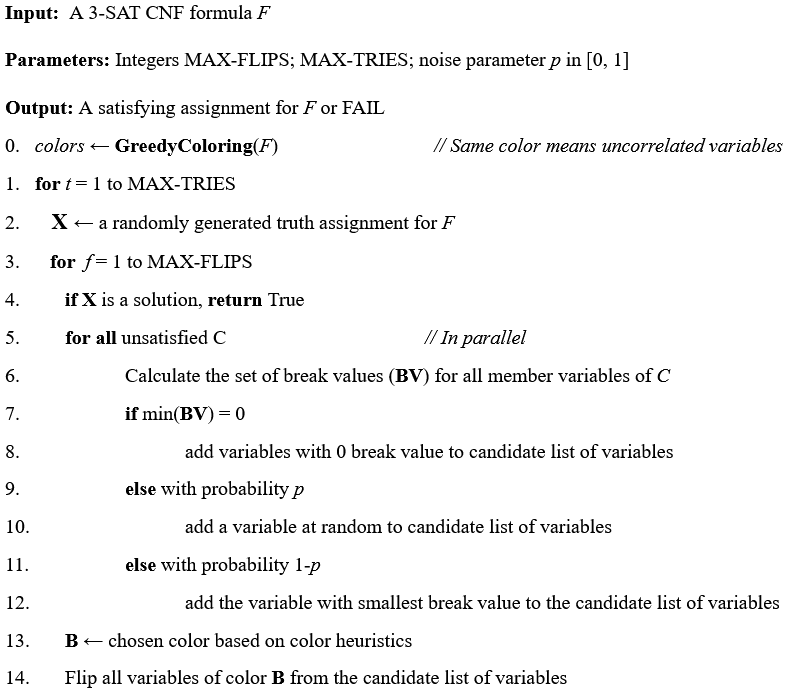

In [2]:
def read_dimacs(filename): # int num_vars, array clauses
    clauses = []
    with open(filename, 'r') as file:
        for line in file:
            if line.startswith('p'):
                parts = line.strip().split()
                if len(parts) >= 4:
                    _, _, variables, _ = parts[:4]
                    num_vars = int(variables)
                else:
                    raise ValueError("Invalid CNF file format in 'p' line.")
            elif line.startswith('c') or line.startswith('%') or line.startswith('0'):
                continue
            else:
                clause = list(map(int, line.strip().split()))
                # Remove the trailing 0 if present
                if clause and clause[-1] == 0:
                    clause = clause[:-1]
                if clause:
                    clauses.append(clause)
    return num_vars, clauses

def extract_problem_number(filename) -> int:
    """Extract numerical problem number from filename."""
    basename = os.path.basename(filename)
    num_str = ''.join(filter(str.isdigit, basename)) # jank the digits
    return int(num_str)


In [3]:
def walkSAT(clauses, max_tries, max_flips, p): # assignment, _Tries, _Flips, flips
    flips = 0
    def evaluate_clause(clause, assignment):
        return any((var > 0 and assignment.get(abs(var), False)) or 
                   (var < 0 and not assignment.get(abs(var), False)) for var in clause)

    def get_unsatisfied_clauses(clauses, assignment):
        return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

    def get_variables(clauses):
        return set(abs(var) for clause in clauses for var in clause)

    def flip_variable(assignment, var):
        assignment[var] = not assignment[var]

    for _Tries in range(max_tries):
        variables = list(get_variables(clauses))
        assignment = {var: random.choice([True, False]) for var in variables}
        
        for _Flips in range(max_flips):

            unsatisfied = get_unsatisfied_clauses(clauses, assignment)
            if not unsatisfied:
                return assignment, _Tries, _Flips, flips  # Found a satisfying assignment
            
            clause = random.choice(unsatisfied)
            if random.random() < p:
                # Flip a random variable from the clause
                var_to_flip = abs(random.choice(clause))
            else:
                # Flip a variable that minimizes the number of unsatisfied clauses if flipped
                break_counts = []
                for var in clause:
                    assignment[abs(var)] = not assignment[abs(var)]
                    break_counts.append((len(get_unsatisfied_clauses(clauses, assignment)), abs(var)))
                    assignment[abs(var)] = not assignment[abs(var)]  # Undo the flip
                
                min_break = min(break_counts, key=lambda x: x[0])
                vars_with_min_break = [var for break_count, var in break_counts if break_count == min_break[0]]
                var_to_flip = random.choice(vars_with_min_break)
            
            flip_variable(assignment, var_to_flip)
            flips += 1

    return "FAIL"

In [4]:
from itertools import combinations

def evaluate_clause(clause, assignment):
    return any(
        (var > 0 and assignment.get(abs(var), False)) or
        (var < 0 and not assignment.get(abs(var), False))
        for var in clause
    )

def get_unsatisfied_clauses(clauses, assignment):
    return [clause for clause in clauses if not evaluate_clause(clause, assignment)]

def get_variables(clauses):
    return set(abs(var) for clause in clauses for var in clause)

def flip_variable(assignment, var):
    assignment[var] = not assignment[var]

def GenerateColors(clauses):
    variables = set(abs(literal) for clause in clauses for literal in clause)
    G = nx.Graph()
    G.add_nodes_from(variables)  # Variable adjacency graph

    # If variables appear in the same clause, make an edge
    for clause in clauses:
        vars_in_clause = set(abs(literal) for literal in clause)
        for var1, var2 in combinations(vars_in_clause, 2):
            G.add_edge(var1, var2)

    # Greedy coloring , return dictionary of unique colors (0 to n) for each node
    colors = nx.coloring.greedy_color(G, strategy='largest_first')
    return colors

In [5]:
def process_clause(clause, assignment, clauses, p, color_array):
    variables_in_clause = np.abs(np.array(clause, dtype=int))
    break_counts = []

    # Line 6) Calculate set of break values for all unsat C
    for x in variables_in_clause:
        assignment[x] = ~assignment[x]
        num_new_unsat = 0
        for clause_check in clauses:
            literals_check = np.array(clause_check, dtype=int)
            vars_in_clause_check = np.abs(literals_check).astype(int)
            signs_check = literals_check > 0
            clause_values_check = assignment[vars_in_clause_check]
            clause_evaluation_check = np.where(signs_check, clause_values_check, ~clause_values_check)
            if not np.any(clause_evaluation_check):
                num_new_unsat += 1
        break_counts.append(num_new_unsat)
        assignment[x] = ~assignment[x]

    candidate_list_of_variables = set() # avoid repeats
    if 0 in break_counts:
        freebie = variables_in_clause[break_counts.index(0)]
        candidate_list_of_variables.add((freebie, color_array[freebie]))

    # Pick a random variable or the min-break variable based on p
    if random.random() < p:
        x = np.random.choice(variables_in_clause)
    else:
        min_break = np.min(break_counts)
        min_indices = np.where(break_counts == min_break)[0]
        idx_min = np.random.choice(min_indices)
        x = variables_in_clause[idx_min]
    candidate_list_of_variables.add((x, color_array[x]))
    candidate_list_of_variables = list(candidate_list_of_variables)
    return candidate_list_of_variables

In [6]:
# Algorithm A1 Steps (v2):
import concurrent.futures
def AlgorithmA1(clauses, colors, max_tries, max_flips, p, heuristic_mode=0):
    """    
    clauses: array of clauses from read_cnf() 
    colors: dictionary of color memberships from GenerateColors()
    max_tries: integer of max restarts for algorithm
    max_flips: integer of iterations of algorithm for a given try
    p: probability of greedy vs random selection
    heuristic_mode: 
        0 = greedy in colors from candidate variables to flip
        1 = random from candidate variables to flip
        2 = pick a random color from candidate variables to flip
        3 = always pick first candidate variable in the candidate variables to flip
    """
    color_choice_history = [] # needed this to track how heuristic choices impact the convergence
    flips = 0
    variables = np.array(sorted(get_variables(clauses))) # Sorted list of variables
    # 1-based indexing, because 0 in cnf files is used for line breaks
    num_vars = variables[-1]
    color_array = np.zeros(num_vars + 1, dtype=int)
    for var, color in colors.items():
        color_array[var] = color
    unique_colors = np.unique(color_array[color_array > 0]) # number of unique colors
    
    for _try in range(max_tries):
        # Line 2) Random assignment
        assignment = np.random.choice([True, False], size=num_vars + 1)  # 1 based indexing

        for _flip in range(max_flips):
            # Line 5.a) Gather indeces of UNSAT clauses
            unsat_indices = []
            for idx, clause in enumerate(clauses):
                literals = np.array(clause, dtype=int)
                vars_in_clause = np.abs(literals).astype(int)
                signs = literals > 0
                clause_values = assignment[vars_in_clause]  # Get assignment values
                clause_evaluation = np.where(signs, clause_values, ~clause_values)
                # If none evaluate to 1, add to unsat index
                if not np.any(clause_evaluation):
                    unsat_indices.append(idx)

            if not unsat_indices: # Line 4) If assignment is a solution, return True
                return assignment[1:], _try, _flip, flips, color_choice_history #_flip is iteration count, flips is actual flips

            # Line 5.b) Gather UNSAT clauses
            selected_clauses = [clauses[i] for i in unsat_indices]
            candidate_list_of_variables = []

            with concurrent.futures.ThreadPoolExecutor() as executor: # Line 5) Should be in parallel.
                futures = []
                for clause in selected_clauses:
                    # Use assignment.copy() if you need to avoid concurrent mutation
                    futures.append(
                        executor.submit(process_clause, clause, assignment.copy(),
                                        clauses, p, color_array)
                    )

                for future in concurrent.futures.as_completed(futures):
                    candidate_list_of_variables.extend(future.result())

            # Line 13) Prepare the candidate list of variables for heuristics
            color_to_candidates = {}
            for x, color in candidate_list_of_variables:
                color_to_candidates.setdefault(color, []).append(x)

            # Line 14) Flip all variables of color B based on heuristics:
            # 1/4/25 added color tracking 
            if heuristic_mode == 0:
                # 5a) Flip variables of the color with the largest number of variables
                selected_color = max(color_to_candidates.keys(), key=lambda c: len(color_to_candidates[c]))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 1:
                # 5b) Randomly pick a variable from candidate variables to flip
                var_to_flip = np.random.choice([x for x, _ in candidate_list_of_variables])
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
            elif heuristic_mode == 2:
                # 5c) Randomly pick a color, flip all variables of that color
                selected_color = np.random.choice(list(color_to_candidates.keys()))
                candidates_in_color = color_to_candidates[selected_color]
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 3:
                # 5d) Always pick the first candidate variable to flip
                var_to_flip = candidate_list_of_variables[0][0]
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
    return "FAIL"

In [7]:
# Algorithm A1 Steps (v2):
# Modified Jan 22 2025
# with VIPSat color iteration ideas
import concurrent.futures
from itertools import cycle
def AlgorithmA1(clauses, colors, max_tries, max_flips, p, heuristic_mode=0):
    """    
    clauses: array of clauses from read_cnf() 
    colors: dictionary of color memberships from GenerateColors()
    max_tries: integer of max restarts for algorithm
    max_flips: integer of iterations of algorithm for a given try
    p: probability of greedy vs random selection
    heuristic_mode: 
        0 = greedy in colors from candidate variables to flip
        1 = random from candidate variables to flip
        2 = pick a random color from candidate variables to flip
        3 = always pick first candidate variable in the candidate variables to flip
        4 = Iterate colors in a cycle that is always RGBRGBRGB ... for (RGB) unique colors
    """
    color_choice_history = [] # needed this to track how heuristic choices impact the convergence
    flips = 0
    variables = np.array(sorted(get_variables(clauses))) # Sorted list of variables
    # 1-based indexing, because 0 in cnf files is used for line breaks
    num_vars = variables[-1]
    color_array = np.zeros(num_vars + 1, dtype=int)
    for var, color in colors.items():
        color_array[var] = color
    unique_colors = np.unique(color_array[color_array > 0]) # number of unique colors
    color_cycle = cycle(unique_colors)
    for _try in range(max_tries):
        # Line 2) Random assignment
        assignment = np.random.choice([True, False], size=num_vars + 1)  # 1 based indexing

        for _flip in range(max_flips):
            # Line 5.a) Gather indeces of UNSAT clauses
            unsat_indices = []
            for idx, clause in enumerate(clauses):
                literals = np.array(clause, dtype=int)
                vars_in_clause = np.abs(literals).astype(int)
                signs = literals > 0
                clause_values = assignment[vars_in_clause]  # Get assignment values
                clause_evaluation = np.where(signs, clause_values, ~clause_values)
                # If none evaluate to 1, add to unsat index
                if not np.any(clause_evaluation):
                    unsat_indices.append(idx)

            if not unsat_indices: # Line 4) If assignment is a solution, return True
                return assignment[1:], _try, _flip, flips, color_choice_history #_flip is iteration count, flips is actual flips

            # Line 5.b) Gather UNSAT clauses
            selected_clauses = [clauses[i] for i in unsat_indices]
            candidate_list_of_variables = []

            # I was doing thread-level parallelism
            # Now let's try process level parallelism ()  ProcessPoolExecutor. ThreadPoolExecutor
            # As a rule of thumb, processes for isolation, threads for speed
            # processes for easier communication than in multithreading // also if you're coding C++ code
            # or something of that sort, processes are usually easier to debug

            with concurrent.futures.ThreadPoolExecutor() as executor: # Line 5) Should be in parallel.
                futures = []
                for clause in selected_clauses:
                    # Use assignment.copy() if you need to avoid concurrent mutation
                    # or in EE/HW terms: to avoid race conditions.
                    futures.append(
                        executor.submit(process_clause, clause, assignment.copy(),
                                        clauses, p, color_array)
                    )

                for future in concurrent.futures.as_completed(futures):
                    candidate_list_of_variables.extend(future.result())

            # Line 13) Prepare the candidate list of variables for heuristics
            color_to_candidates = {}
            for x, color in candidate_list_of_variables:
                color_to_candidates.setdefault(color, []).append(x)

            # Line 14) Flip all variables of color B based on heuristics:
            # 1/4/25 added color tracking
            # 1/23/25 added extra heuristic and made assignments pedantic 
            if heuristic_mode == 0:
                # 5a) Flip variables of the color with the largest number of variables
                selected_color = max(color_to_candidates.keys(), key=lambda c: len(color_to_candidates[c]))
                candidates_in_color = color_to_candidates[selected_color]
                candidates_in_color = set(candidates_in_color) # remove duplicates just in case, but my code handles them fine
                candidates_in_color = list(candidates_in_color)
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 1:
                # 5b) Randomly pick a variable from candidate variables to flip
                var_to_flip = np.random.choice([x for x, _ in candidate_list_of_variables])
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
            elif heuristic_mode == 2:
                # 5c) Randomly pick a color, flip all variables of that color
                selected_color = np.random.choice(list(color_to_candidates.keys()))
                candidates_in_color = color_to_candidates[selected_color]
                candidates_in_color = set(candidates_in_color) # remove duplicates just in case, but my code handles them fine
                candidates_in_color = list(candidates_in_color)
                assignment[candidates_in_color] = ~assignment[candidates_in_color]
                flips += len(candidates_in_color)
                color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
            elif heuristic_mode == 3:
                # 5d) Always pick the first candidate variable to flip
                var_to_flip = candidate_list_of_variables[0][0]
                assignment[var_to_flip] = ~assignment[var_to_flip]
                flips += 1
                color_choice_history.append({"color": color_array[var_to_flip], "flips": 1})
            elif heuristic_mode == 4:
                # 5e) VIP-SAT idea: just go RGBRGBRGB and discard if you do not flip 
                selected_color = next(color_cycle)
                try:                
                    candidates_in_color = color_to_candidates[selected_color]
                    candidates_in_color = set(candidates_in_color) # remove duplicates just in case
                    candidates_in_color = list(candidates_in_color)
                    assignment[candidates_in_color] = ~assignment[candidates_in_color]
                    flips += len(candidates_in_color)
                    color_choice_history.append({"color": selected_color, "flips": len(candidates_in_color)})
                except:
                    # If you do not do anything then do not log anything
                    color_choice_history.append({"color": None, "flips": None})


    return "FAIL"

In [11]:
max_flips_var = 10
noise_value = 0.5
chosen_heuristic = 1 
chosen_max_tries = 1
cnf_file = "/home/dae/SatExperiments/ColoringWalksatExperiments/TestFolderCNF/uf5004.cnf"
problem_name = os.path.basename(cnf_file)
num_vars, clauses = read_dimacs(cnf_file)
start = time.perf_counter()
colors = GenerateColors(clauses)
solution_object = AlgorithmA1(clauses, colors, max_tries=chosen_max_tries, max_flips=max_flips_var, p=noise_value, heuristic_mode=chosen_heuristic)
end = time.perf_counter()

In [12]:
solution_object

'FAIL'

In [55]:
# Now what to plot:

# a Run length distribution
# b Success rate - modify below code with tinish def
# c Instance-wise flips to solution (done; just a number)
# d Batch wise flips to solution (done) - modify below code

# e Color choice distribution for the batch - take the per-instance and do for batch (most common)
# f Color choice during solving per instance (done above)
# g Color choice domain plots with instance-wise flips to solution range (combine e and c)
# h Parallelism % domain heuristic plots with instance-wise flips to solution range (needs new)

In [13]:
# Modified just to run everything no plots
# then dumps to a sql
# also the metricsare in myWalksat.py
# 01/13/2025: modified so I can append 100 times instead of setting max_tries == 100...
# because otherwise, huzzah I cannot find the TTS99 idea properly
# 1/16/2025 modified to use walksat instead
# 01/23/2025 modifying so we are working on A4 now

# 
import sqlite3
import os
import glob
import json
import time
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import Counter
import pandas as pd

def process_file(cnf_file):
    import time
    max_flips_var = 10000
    noise_value = 0.5
    chosen_heuristic = 0 
    chosen_max_tries = 1

    problem_name = os.path.basename(cnf_file)
    num_vars, clauses = read_dimacs(cnf_file)
    start = time.perf_counter()
    colors = GenerateColors(clauses)
    # AlgorithmA1(clauses, colors, max_tries=chosen_max_tries, max_flips=max_flips_var, p=noise_value, heuristic_mode=chosen_heuristic)
    # walkSAT(clauses, max_tries=chosen_max_tries, max_flips=max_flips_var, p=noise_value)
    solution_object = AlgorithmA1(clauses, colors, max_tries=chosen_max_tries, max_flips=max_flips_var, p=noise_value, heuristic_mode=chosen_heuristic)
    end = time.perf_counter()

    # flips is taken flips, iterations is what flips stands for in regular wsat
    if solution_object != "FAIL":  # we found a satisfying model
        time_to_solution = end - start  # seconds
        assignment, tries, iterations, flips, color_order =  solution_object # color_order REMEMBER TO ADD OR REMOVE! depending what benchmarking doing
        print(f"{problem_name}: Time = {time_to_solution:.4f}s, Flips = {flips}")
        colors_order_iter = [entry["color"] for entry in color_order] # REMEMBER TO CHANGE
        flips_iter = [entry["flips"] for entry in color_order] #[entry["flips"] for entry in color_order]
        counts = Counter(colors)
        return (problem_name, time_to_solution, noise_value, tries, iterations, flips, colors_order_iter, flips_iter) # tuple of problem name, TTS, flips
    else:
        print(f"{problem_name}: Failed to find a solution")
        # Return None for time and flips (thanks George for suggestion)
        return (problem_name, None, None, None, None, None, None, None)


# changed this to append to the save csv over and over again up to the 100 tries we needed.
# so now 100 tries of 1 maxtries each
def main():
    # CSV file path
    csv_file = 'Coloring_H0_Uf100_P05_Tries100_Flips10000.csv'
    
    # Remove existing CSV to start fresh
    if os.path.exists(csv_file):
        os.remove(csv_file)
        print(f"Existing CSV '{csv_file}' removed. Starting fresh.")
    # let us solve the first 100 problems only for speed
    cnf_directory = "/home/dae/SatExperiments/ColoringWalksatExperiments/first100uf100"
    cnf_files = glob.glob(os.path.join(cnf_directory, "uf100*.cnf")) # get all uf50* files
    cnf_files.sort(key=extract_problem_number) # sort files based on numerical part filename

    total_cpus = multiprocessing.cpu_count()
    num_workers = max(1, int(total_cpus * 0.9)) # using 90% of cores
    print(f"Total CPU cores: {total_cpus}, Using {num_workers} worker processes.")

    # Open the CSV file in append mode
    for run_id in range(1, 101):  # Runs 1 to 100 201 means 200 tries now
        print(f"Starting run {run_id}/100")
        with multiprocessing.Pool(processes=num_workers) as pool: # do the benchmarking in parallel using independent processes
            results = pool.map(process_file, cnf_files)

        if results: # problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list
            problem_names, times_to_solution, p, tries_to_solution, iterations_to_solution, flips_to_solution, colors_order_iter_list, flips_iter_list = zip(*results)
            
            dict_results = {
                'run_id': [run_id]*len(problem_names),
                'problem_name': problem_names, 
                'time_to_solution': times_to_solution, 
                'noise_param': p, 
                'tries': tries_to_solution, 
                'iterations': iterations_to_solution, 
                'flips': flips_to_solution,
                'order_of_colors': colors_order_iter_list, 
                'order_of_parallel_flips': flips_iter_list
            }    
            df = pd.DataFrame(dict_results)
            
            # Append to CSV
            if run_id == 1:
                df.to_csv(csv_file, mode='w', index=False)
                print(f"Run {run_id}: Data written to '{csv_file}' with headers.")
            else:
                df.to_csv(csv_file, mode='a', header=False, index=False)
                print(f"Run {run_id}: Data appended to '{csv_file}'.")
        else:
            print("No results error in run {run_id}.")
            continue  # Proceed to the next run

    print("All runs completed.")

if __name__ == "__main__":
    main()


Total CPU cores: 64, Using 57 worker processes.
Starting run 1/100
uf100-018.cnf: Time = 32.8924s, Flips = 492
uf100-030.cnf: Time = 33.2459s, Flips = 432
uf100-039.cnf: Time = 34.5722s, Flips = 422
uf100-037.cnf: Time = 39.1823s, Flips = 491
uf100-025.cnf: Time = 50.8532s, Flips = 743
uf100-031.cnf: Time = 51.3229s, Flips = 912
uf100-02.cnf: Time = 53.5031s, Flips = 1200
uf100-064.cnf: Time = 20.5940s, Flips = 209
uf100-058.cnf: Time = 44.3953s, Flips = 682
uf100-035.cnf: Time = 88.7286s, Flips = 1044
uf100-024.cnf: Time = 93.2869s, Flips = 2584
uf100-06.cnf: Time = 96.0417s, Flips = 2074
uf100-041.cnf: Time = 109.9101s, Flips = 2023
uf100-063.cnf: Time = 91.4908s, Flips = 1416
uf100-049.cnf: Time = 157.2434s, Flips = 2048
uf100-071.cnf: Time = 16.6760s, Flips = 165
uf100-012.cnf: Time = 161.3610s, Flips = 3328
uf100-056.cnf: Time = 163.2788s, Flips = 4179
uf100-074.cnf: Time = 11.8191s, Flips = 109
uf100-070.cnf: Time = 79.6448s, Flips = 1597
uf100-013.cnf: Time = 211.5958s, Flips = 